# Simpler Scaler and Encoder

The idea with this notebook is to achieve a simpler read/scale/encode/decode/unscale process for `trader`.

It must be based on simple contracts between objects, which are also based on standard classes (DataFrames, ndarrays) instead of specific objects from the project.

Expected usage:

    # Read the OHLCV file
    ticks = Ticks(url, scale=True, *args, **kwargs)
    
    # Original data read from the file can be accessed easily
    ticks.raw
    
    # Scaled data is also accessible
    ticks.data
    
    # If we need to encode it, we can also do it, and later access 
    # the result from within the object property,
    ticks.encode()
    ticks.encoded
    
    # ... or simply capture the output from the encode() method
    encoded = ticks.encode()
    
One we have the ticks read from the file, we might need to prepare them for the LSTM. To do that we must use another specific class, called Sequences.

The contract with the class is either a multivariate time series, stored in a dataframe. So we can pass an:

  - Univariate time series with float values
  - Univariate time series with binary values (encoded)
  - Multivariate time series with floats
  - Multivariate time series with binary values (encoded)
 
Sequences needs to know what is the total number of time series in the data (the number of variables or categories) and the number of time steps in which the time series will be grouped to be later feed into the recurrent networks. An optional final parameter also needed is the test size ratio (0.1, 0.2, etc.) which takes a value of 0.1 by default.

The expected use is as follows:

    # If we want to prepare the data in Ticks object, unencoded:
    X_train, y_train, X_test, y_test = sequences.prepare(
        ticks.data, 
        timesteps=window_size, 
        test_size=test_size
    )
    
or

    # If we want to prepare the data in Ticks object ENCODED:
    ticks.encode()
    X_train, y_train, X_test, y_test = sequences.prepare(
        ticks.encoded,
        timesteps=window_size
    )
    
    

In [1]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

from numpy import ndarray
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from pandas import DataFrame, Series
from pathlib import Path
from math import ceil, floor
from numpy import ndarray
from typing import Tuple, Union

from keras.layers import LSTM, Dense, Dropout
from keras.metrics import categorical_crossentropy
from keras.models import Sequential, model_from_json
from keras.regularizers import l2

## Notebook Preparation

In [2]:
%load_ext lab_black

url = "/Users/renero/Documents/SideProjects/trader/data/^GDAXI/DAX_2018_2019.csv"
scaler_filename = "/Users/renero/robust_scaler.gz"


class my_dict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


pd.set_option("display.max_columns", 1000)
pd.set_option("max_seq_items", 1000)
pd.set_option("display.width", 1000)
np.set_printoptions(threshold=np.inf)

# Ticks Class definition (⚡️)

In [3]:
class Ticks:
    """Ticks data read from file with all the relevant parameters and metadata from it"""

    data = None
    _scaler = None
    scaler_file = None
    _encoder = None
    _volatility = 0.0

    params = my_dict({"ohlc": ["open", "high", "low", "close"]})

    def __init__(self, url, scale=False):
        data = pd.read_csv(url).round(2)

        format = "%Y-%m-%d %H:%M:%S"
        data["Datetime"] = pd.to_datetime(data["Date"] + " 00:00:00", format=format)
        data = data.set_index(pd.DatetimeIndex(data["Datetime"]))
        data = data.drop(["Date", "Datetime", "Volume"], axis=1)
        data.columns = self.params.ohlc
        self.data = data
        self.raw = self.data.copy(deep=True)
        if scale is True:
            self.data = self.transform()
        self._volatility = self.data.close.std()

    def transform(self, inline: bool = False) -> DataFrame:
        """Scales the OHLC ticks from the dataframe read"""
        self._scaler = RobustScaler().fit(self.data[self.params.ohlc])
        scaled_df = pd.DataFrame(
            data=self._scaler.transform(self.data[self.params.ohlc]),
            columns=self.params.ohlc,
            index=self.data.index,
        ).round(2)
        if not inline:
            return scaled_df
        self.raw = self.data.copy(deep=True)
        self.data = scaled_df.copy(deep=True)
        self._volatility = self.data.close.std()
        return self.data

    def inverse_transform(self, scaled_df: DataFrame) -> DataFrame:
        """Scales back a dataframe with the scaler stored in filename"""
        assert self._scaler is not None, "Scaler must be set first (scale())"
        return pd.DataFrame(
            data=self._scaler.inverse_transform(scaled_df[self.params.ohlc]),
            columns=self.params.ohlc,
            index=scaled_df.index,
        ).round(2)

    def encode(self, num_slots=10) -> np.ndarray:
        """Encode (OneHot) the discretized version of values in attribute `data`"""
        assert (
            self._scaler is not None
        ), "Data has not been scaled yet. Use 'transform()'"
        self._discretized = self._discretize(num_slots)
        self._edge = max(
            self._discretized.max().max(), abs(self._discretized.min().min())
        )
        self._categories = [
            np.arange(-self._edge, self._edge + 1)
            for _ in range(len(self.data.columns))
        ]
        self._encoder = OneHotEncoder(
            handle_unknown="ignore", categories=self._categories
        ).fit(self._discretized)
        self._encoded = self._encoder.transform(self._discretized).toarray()
        return self._encoded

    def decode(self, prediction: int, prev_value: float, verbose=False):
        activated = np.argmax(prediction)
        if verbose:
            print(f"Cell activated: {activated} out of {prediction.shape[0]}")
            # print(f"Value: {np.round(prediction[activated],2)}")

        pred_binary = np.identity(prediction.shape[0], int)[prediction.argmax()]
        if verbose:
            print(f"Prediction hardmaxed: {pred_binary}")
            print(f"Categories used in encoder: {ticks._categories[0]}")

        # Have to copy the response from the net 4 times, as the encoder is 'fitted'
        # with 4 vectors, corresponding to O/H/L/C.
        to_decode = np.tile(pred_binary, ticks.data.shape[1]).reshape(
            1, X_train.shape[2]
        )
        decoded_bin = ticks._encoder.inverse_transform(to_decode)[0][0]
        diff_with_previous = (
            np.sign(decoded_bin) * np.abs(ticks._bins[decoded_bin])
        ) - (self._bin_size / 2.0)
        decoded_value = np.round(
            (prev_value + (diff_with_previous * self._volatility)), 2
        )
        if verbose:
            print(
                f"Decoded_diff: {decoded_bin}, corresponding to {diff_with_previous}% change"
            )
            print(f">> DECODED value: {decoded_value} (previous: {prev_value})")

        return decoded_value

    def _discretize(self, num_slots=10) -> DataFrame:
        """Discretize the rolling difference in num_slots of volatility of time series"""
        self._num_slots = num_slots
        self._diffed = self._diff()
        self._bin_size = ticks._volatility / self._num_slots
        self._bins = np.arange(0.0, self._volatility + self._bin_size, self._bin_size)[
            1:
        ]
        self._bins = np.around(self._bins, decimals=2)
        return self._diffed.apply(
            lambda row: round(row / self._bin_size), result_type="expand", axis=1
        ).astype(int)

    def _diff(self) -> DataFrame:
        """Returns a dataframe with each row being the difference with its previous one"""
        return (
            self.data.rolling(window=2)
            .apply(lambda row: row.iloc[1] - row.iloc[0])
            .round(2)
            .fillna(0.00)
        )

    def save_scaler(self, filename: str) -> None:
        """
        Saves the scaler with the filename specified
        
        :param filename: The complete path and filename where the scaler will be saved
        :returns: None
        :raises AssertionError: raises if scaler is not set before trying to save it
        """
        assert (
            self._scaler is not None
        ), "Scaler has not yet been created. Use scale() method first."
        self.scaler_file = filename
        joblib.dump(self._scaler, self._scaler_file)
        print(f"RobustScaler saved at: {self._scaler_file}")

    def load_scaler(self, filename: str):
        """Loads the scaler from the filename specified"""
        self.scaler_file = filename
        self._scaler = joblib.load(self._scaler_file)
        return self._scaler

    @property
    def scaler_file(self) -> str:
        if hasattr(self, "_scaler_file"):
            return self._scaler_file.as_posix()
        return None

    @scaler_file.setter
    def scaler_file(self, filename):
        file = Path(filename)
        if not file.is_file():
            raise ValueError("Filename for scaler does not exist")
        self._scaler_file = file

## Test 1
Read CSV, scale and back!

            open  high   low  close
Datetime                           
2018-01-02  0.71  0.66  0.61   0.67
2018-01-03  0.73  0.78  0.77   0.79
2018-01-04  0.90  0.99  0.96   1.00
                open      high       low     close
Datetime                                          
2018-01-02  12896.00  12921.95  12744.11  12867.73
2018-01-03  12914.15  13027.61  12889.98  12976.55
2018-01-04  13068.50  13212.51  13063.20  13166.97


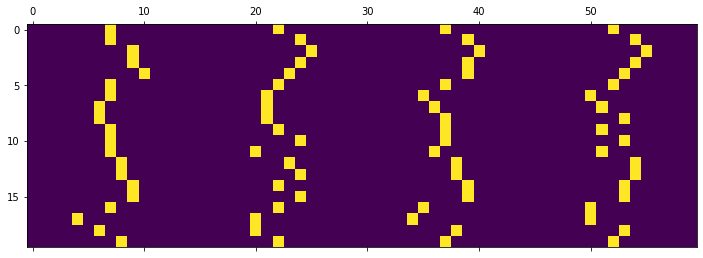

In [4]:
ticks = Ticks(url, scale=True)
print(ticks.data.head(3))

reversed_df = ticks.inverse_transform(ticks.data)
print(reversed_df.head(3))

trf = ticks.encode()
plt.matshow(trf[:20])

## Test 2

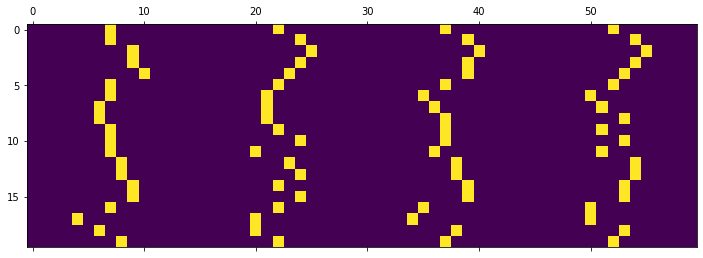

In [5]:
ticks = Ticks(url)
ticks.transform(inline=True)
matrix = ticks.encode()
plt.matshow(matrix[:20])

## Test 3

RobustScaler saved at: /Users/renero/robust_scaler.gz


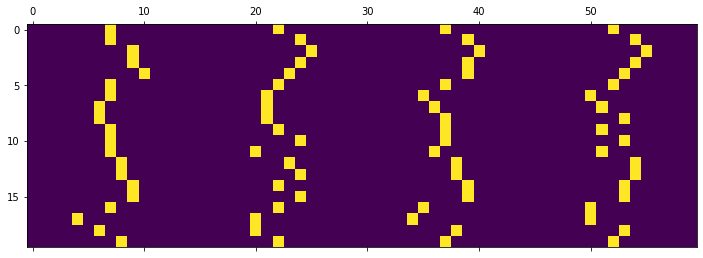

In [6]:
ticks = Ticks(url)
ticks.transform(inline=True)
ticks.save_scaler(scaler_filename)
matrix = ticks.encode()
plt.matshow(matrix[:20])

----
# Sequences (⚡️)

In [7]:
class sequences:
    """
    From a dataframe with four categories (OHLC) in a multivariate timeseries,
    aggrupate it in timesteps windows, split it in training and testing subsets, and 
    finally, aggrupate X and y values together.

    Consider a given multi-variate sequence (num_categories = 3):

        [[ 10  15  25]
         [ 20  25  45]
         [ 30  35  65]
         [ 40  45  85]
         [ 50  55 105]
         ...
        ]

    We can divide the sequence into multiple input/output patterns called samples, 
    where three time steps are used as input and one time step is used as output for 
    the one-step prediction that is being learned.

         X,             y_3
        --------------------
        [10, 15, 25	
         20, 25, 45	
         30, 35, 65]    85
        [20, 25, 45
         30, 35, 65
         40, 45, 85]    105
        ...

    In this example we consider timesteps=3, so X is composed of 
    [ timesteps x num_categories ] samples, and y is the third column of 
    the next sample.

    """

    def __init__(self):
        pass

    @classmethod
    def prepare(
        cls, df: DataFrame, timesteps: int, test_size: float = 0.1
    ) -> Union[Tuple[ndarray, ndarray, ndarray, ndarray], Tuple[ndarray, ndarray]]:
        """
        Prepare the input dataframe (OHLC) converting it into an ndarray
        of (num_samples x timesteps x num_categories), also splitting it
        into training and test sets.
        """
        num_categories = df.shape[1]

        df = cls.aggrupate_in_timesteps(df, timesteps)
        if test_size != 0.0:
            train, test = train_test_split(df, test_size=test_size, shuffle=False)
            X_train, y_train = cls.split_Xy(train, timesteps)
            X_test, y_test = cls.split_Xy(test, timesteps)
            return X_train, y_train, X_test, y_test

        return cls.split_Xy(df, timesteps)

    @classmethod
    def aggrupate_in_timesteps(cls, data: ndarray, timesteps: int) -> DataFrame:
        """
        Given a dataframe, divide the sequence into multiple input/output 
        patterns called samples, where a number of time steps are used as 
        input and one time step is used as output for the one-step prediction 
        that is being learned.
        """
        df = pd.DataFrame(data)
        series = df.copy(deep=True)
        series_s = series.copy(deep=True)
        for i in range(timesteps):
            series = pd.concat([series, series_s.shift(-(i + 1))], axis=1)
        series.dropna(axis=0, inplace=True)
        return series

    @classmethod
    def split_Xy(cls, data: ndarray, timesteps) -> Tuple[ndarray, ndarray]:
        """
        Take num_samples from data, and separate X and y from it into two
        new tensors that will be used to feed the LSTM.
        """
        num_samples = data.shape[0]
        num_categories = int(data.shape[1] / (timesteps + 1))
        subset = np.array(data).reshape((num_samples, timesteps + 1, num_categories))

        X = subset[:, 0:timesteps, :]

        # maybe, data is encoded. In that case I must keep, NOT the last column
        # but the last $ num_categories / 4 $, which corresponds to the encoded
        # values of the last column, corresponding to the "close" value.
        from_column_index = int(num_categories - (num_categories / 4))
        to_column_index = num_categories
        y = subset[:, -1, from_column_index:to_column_index]

        return X, y

    @classmethod
    def _last_index_in_training(
        cls, df: DataFrame, timesteps: int, test_size: float = 0.1
    ) -> int:
        """Returns the last value in the training set, from the original dataframe"""
        train_size = 1.0 - test_size
        n_samples = df.shape[0]
        n_test = ceil(test_size * n_samples)
        n_train = floor(train_size * n_samples)
        last_index_in_train = n_train - timesteps - 1
        return last_index_in_train

    @classmethod
    def last_in_training(
        cls, df: DataFrame, timesteps: int, test_size: float = 0.1
    ) -> Series:
        return ticks.data.iloc[cls._last_index_in_training(df, timesteps, test_size)]

    @classmethod
    def first_in_test(
        cls, df: DataFrame, timesteps: int, test_size: float = 0.1
    ) -> Series:
        return ticks.data.iloc[
            cls._last_index_in_training(df, timesteps, test_size) + 1
        ]

----
# Test Sequences (success !!) 😀

Read the 100 OHLC values

In [8]:
timesteps = 4

ticks = Ticks(url, scale=True)
df = ticks.data.copy(deep=True)
print(f"Ticks shape: {ticks.data.shape}\n{df.head().values}")

Ticks shape: (480, 4)
[[0.71 0.66 0.61 0.67]
 [0.73 0.78 0.77 0.79]
 [0.9  0.99 0.96 1.  ]
 [1.07 1.13 1.13 1.17]
 [1.26 1.21 1.26 1.22]]


In [9]:
ticks_encoded = ticks.encode()
print(f"Ticks encoded shape: {ticks_encoded.shape}")
print(ticks_encoded[:3])

Ticks encoded shape: (480, 60)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [10]:
X_train, y_train, X_test, y_test = sequences.prepare(
    ticks.data, timesteps=timesteps, test_size=0.1
)

print("X_train:\n", X_train[0:3], "\ny_train:\n", y_train[0:3])
print("---")
print("X_test:\n", X_test[0:3], "\ny_test:\n", y_test[0:3])

X_train:
 [[[0.71 0.66 0.61 0.67]
  [0.73 0.78 0.77 0.79]
  [0.9  0.99 0.96 1.  ]
  [1.07 1.13 1.13 1.17]]

 [[0.73 0.78 0.77 0.79]
  [0.9  0.99 0.96 1.  ]
  [1.07 1.13 1.13 1.17]
  [1.26 1.21 1.26 1.22]]

 [[0.9  0.99 0.96 1.  ]
  [1.07 1.13 1.13 1.17]
  [1.26 1.21 1.26 1.22]
  [1.25 1.23 1.29 1.24]]] 
y_train:
 [[1.22]
 [1.24]
 [1.13]]
---
X_test:
 [[[-0.   -0.09 -0.05 -0.03]
  [-0.03 -0.03  0.04  0.03]
  [ 0.08  0.07  0.15  0.13]
  [ 0.13  0.11  0.17  0.19]]

 [[-0.03 -0.03  0.04  0.03]
  [ 0.08  0.07  0.15  0.13]
  [ 0.13  0.11  0.17  0.19]
  [ 0.24  0.18  0.08  0.  ]]

 [[ 0.08  0.07  0.15  0.13]
  [ 0.13  0.11  0.17  0.19]
  [ 0.24  0.18  0.08  0.  ]
  [-0.03 -0.13 -0.29 -0.37]]] 
y_test:
 [[ 0.  ]
 [-0.37]
 [-0.27]]


----
# Experimentation here !! 👨‍ 🔬 🧪

## Metrics and Results display (⚡️)

In [11]:
def fail(y, y_prev, yhat):
    return np.sign(y - y_prev) != np.sign(yhat - y_prev)


def plot_and_compare(df: DataFrame):
    fails = 0
    plt.figure(figsize=(14, 8))
    for i in range(1, df.shape[0]):
        segment_color = "red"
        lw = 0.8
        alpha = 0.6
        if i > 0:
            if not fail(df.iloc[i].y, df.iloc[i - 1].y, df.iloc[i].yhat):
                segment_color = "green"
                lw = 1.0
                alpha = 1.0
            else:
                fails += 1

        plt.plot(
            [i - 1, i],
            [df.y.iloc[i - 1], df.y.iloc[i]],
            marker=".",
            linewidth=0.8,
            linestyle="--",
            alpha=0.4,
            color="black",
        )
        plt.plot(
            [i - 1, i],
            [df.y.iloc[i - 1], df.yhat.iloc[i]],
            linewidth=1.0,
            # alpha=alpha,
            color=segment_color,
        )

    hits = df.shape[0] - fails
    plt.title(
        f"Aciertos ({hits}/{100*(hits/df.shape[0]):.2f}%) y fallos ({fails}/{100*(fails/df.shape[0]):.2f}%) de tendencia"
    )
    plt.show()


def trend_performance(df):
    fails = 0
    for i in range(1, df.shape[0]):
        if i > 0:
            if fail(df.iloc[i].y, df.iloc[i - 1].y, df.iloc[i].yhat):
                fails += 1
    return (df.shape[0] - fails) / df.shape[0]


def mean_error(df):
    cum_distance = 0.0
    for i in range(1, df.shape[0]):
        cum_distance += np.abs(df.y.iloc[i] - df.yhat.iloc[i])
    return cum_distance / df.shape[0]

## Data reading (and/or encoding)

In [12]:
window_size = 4
test_size = 0.1

ticks = Ticks(url, scale=True)
# ticks.encode()
X_train, y_train, X_test, y_test = sequences.prepare(
    ticks.data, timesteps=window_size, test_size=test_size
)
print(f"X_train {X_train.shape}, y_train{y_train.shape}")
print(f"X_test {X_test.shape}, y_test{y_test.shape}")

# This is to know if data is coming in encoded (onehot) or not.
binary_encoded = ((y_train == 0.0) | (y_train == 1.0)).all()

X_train (428, 4, 4), y_train(428, 1)
X_test (48, 4, 4), y_test(48, 1)


## Parameters

In [13]:
l1units = 128
l2units = 128
dropout = 0.1
activation = "tanh"

num_categories = X_train.shape[2]
num_predictions = y_train.shape[1]
tensorboard = True

loss = "binary_crossentropy" if binary_encoded else "mean_squared_error"
optimizer = "adam"
metrics = ["categorical_crossentropy"] if binary_encoded else ["mse"]

## LSTM creation / TensorBoard launch

In [14]:
tf.random.set_seed(123)
model = Sequential()
model.add(
    LSTM(
        input_shape=(window_size, num_categories),
        return_sequences=True,
        units=l1units,
        kernel_regularizer=l2(0.0000001),
        activity_regularizer=l2(0.0000001),
    )
)
model.add(Dropout(dropout))
model.add(
    LSTM(
        l2units, 
        kernel_regularizer=l2(0.0000001), 
        activity_regularizer=l2(0.0000001))
)
model.add(Dropout(dropout))
model.add(Dense(num_predictions, activation=activation))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.summary()

callbacks = []
log_dir = (
    "logs/fit/"
    + f"ws{window_size:02d}_"
    + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

## TensorBoard launch

!rm -rf logs/*
%load_ext tensorboard
%tensorboard --logdir logs

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 128)            68096     
_________________________________________________________________
dropout (Dropout)            (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________


Launching TensorBoard...

KeyboardInterrupt: 

## Training

In [ ]:
epochs = 600
verbose = 0
batch_size = 1
validation_split = 0.1

model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=verbose,
    validation_split=validation_split,
    callbacks=callbacks,
    use_multiprocessing=True,
)

## Make prediction

In [ ]:
yhat = model.predict(X_test)
print(f"Predictions (yhat): {yhat.shape}")

n_predictions = int(X_test.shape[0])
print(f"n_predictions: {n_predictions}")

## Decoding onehot prediction

In [ ]:
if binary_encoded:
    last = sequences.last_in_training(ticks.data, window_size, test_size).close
    ticks.decode(yhat[0], last, verbose=1)

### Decode the entire set of predictions

In [ ]:
if binary_encoded:
    decoded = []
    last_index = sequences._last_index_in_training(ticks.data, window_size, test_size)
    last_value = ticks.data.iloc[last_index + window_size].close

    for i in range(yhat.shape[0]):
        this_value = ticks.decode(yhat[i], last_value)
        decoded.append(this_value)
        last_index += 1
        last_value = ticks.data.iloc[last_index].close

    print(f"decoded size: {len(decoded)}\n{decoded}")

## Display results

In [ ]:
if binary_encoded:
    last_index = sequences._last_index_in_training(ticks.data, window_size, test_size)
    Y = ticks.data.iloc[last_index + 1 + window_size :].close.values.reshape(
        n_predictions,
    )
    Yhat = np.array(decoded).reshape(n_predictions,)
else:
    Y = y_test.reshape(n_predictions,)
    Yhat = yhat.reshape(n_predictions,)

results = pd.DataFrame({"y": Y, "yhat": Yhat,}).round(2)
print(
    f"Mean Err.: {mean_error(results):5.3f}, Trend perf.: {trend_performance(results):4.2f}"
)

plot_and_compare(results)

Mores resultados con 400 epocs, batch_size = 1, window_size = 4, unencoded (60% aciertos de tendencia).

----
## Summary Results

Compare UNencoded version (LSTM feed with floats) against ENCODED version (LSTM encoded with binary arrays).

    window_size = 4
    test_size = 0.1

DAX_2018_2019 (floats)

| epochs | Mean err. (unencoded) | Trend perf (unencoded)|
|--------|-----------------------|-----------------------|
| 100    | 0.082                 | 0.54                  |
| 200    | 0.073                 | 0.62                  |
| 400    | 0.078                 | 0.58                  |
| 800    | 0.085                 | 0.58                  |

DAX_2018_2019 (onehot)

| epochs | Mean err. (encoded) | Trend perf (encoded)|
|--------|---------------------|---------------------|
| 100    | 0.374               | 0.40                |
| 200    | 0.308               | 0.40                |
| 400    | 0.298               | 0.46                |
| 800    | 0.307               | 0.35                |

In [ ]:
res_df = DataFrame(
    {
        "mean error unencoded": [0.082, 0.073, 0.078, 0.085],
        "mean error encoded": [0.374, 0.308, 0.298, 0.307],
        "trend performance unencoded": [0.54, 0.62, 0.58, 0.58],
        "trend performance encoded": [0.40, 0.40, 0.46, 0.35],
    },
    index=[100, 200, 400, 800],
)

res_df

In [ ]:
%matplotlib inline
# plt.figure(figsize=(12, 7))
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
res_df[["mean error unencoded", "mean error encoded"]].plot(
    kind="bar", ax=axes[0], alpha=0.6, ylim=(0.0, 1.0)
)

axes[1].axhline(0.5, color="black", linestyle="--", alpha=0.5)
res_df[["trend performance unencoded", "trend performance encoded"]].plot(
    kind="bar", ax=axes[1], alpha=0.6, ylim=(0.0, 1.0)
)

plt.show()